In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from dataset_loader import load
import matplotlib.pyplot as plt
import stanza
from collections import defaultdict
import nltk
from nltk import word_tokenize
from nltk.corpus import brown

nltk.download('brown')
fd = nltk.FreqDist(brown.words())

d:\Miniconda\envs\hugging\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\cyarq\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
dataset_name = 'TruthfulQA'
dataset = load(dataset_name, 'datasets/')

parsing data: 100%|██████████| 785/785 [00:00<00:00, 70374.23it/s]


In [3]:
train_df  = pd.DataFrame.from_dict(dataset['train'])
train_df.head()

,text,label,category
0,The watermelon seeds pass through your digesti...,0,Misconceptions
1,"If you eat watermelon seeds, they will pass th...",1,Misconceptions
2,The precise origin of fortune cookies is unclear,0,Misconceptions
3,Fortune cookies are a traditional dessert in A...,1,Misconceptions
4,Veins appear blue because blue light does not ...,0,Misconceptions


In [ ]:
train_df.to_csv(f'{dataset_name}_train.csv')

In [12]:
def fetch_text(dataset):
    human_text = dataset['text'][dataset.label == 0].tolist()
    machine_text = dataset['text'][dataset.label == 1].tolist()
    return human_text, machine_text

### Answer Length

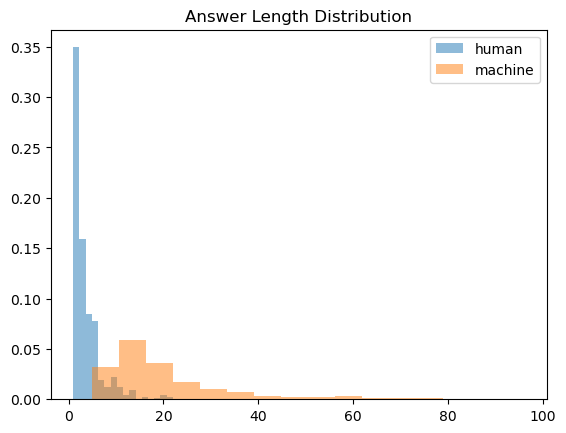

In [13]:
def text_length(all_text):
    list_of_words = [[word for word in word_tokenize(text) if word.isalpha()] for text in all_text]
    list_of_len = [len(words) for words in list_of_words]
    return list_of_len

human_text, machine_text = fetch_text(train_df)

human_len = text_length(human_text)
machine_len = text_length(machine_text)


plt.hist(human_len, bins=16, alpha=0.5, label='human', density=True)
plt.hist(machine_len, bins=16, alpha=0.5, label='machine', density=True)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Answer Length Distribution")
plt.savefig(f'{dataset_name}_length.png')

### Frequent Words

In [32]:
def freq_func(text, fd):
    all_text = ' '.join(text)
    words = word_tokenize(all_text)
    words = [word.lower() for word in words if word.isalpha()]
    freq = [fd[word] for word in words]
    words_len = np.mean([len(word) for word in words])
    rare_words = [word for word in words if fd[word] < 100]
    print(len(rare_words), rare_words)
    norm_freq = np.array(freq)
    return norm_freq, words_len


In [34]:
human_text, machine_text = fetch_text(train_df)

human_freq, human_words_len = freq_func(human_text, fd)
machine_freq, machine_words_len = freq_func(machine_text, fd)

1153 ['april', 'populations', 'peptidoglycan', 'john', 'harvard', 'municipal', 'inspector', 'kpa', 'thousand', 'inhabitants', 'reminding', 'countrymen', 'injustice', 'palm', 'springs', 'robert', 'iger', 'super', 'bowl', 'xliv', 'provisional', 'interim', 'facility', 'relocation', 'fresno', 'japanese', 'americans', 'internment', 'camps', 'october', 'daidu', 'north', 'settlers', 'masovian', 'gothic', 'calendar', 'fixing', 'seasons', 'gold', 'footballs', 'überseering', 'bv', 'v', 'nordic', 'construction', 'gmbh', 'leonardo', 'da', 'vinci', 'catholics', 'channels', 'joining', 'easterly', 'flow', 'atlantic', 'twentieth', 'homes', 'frequency', 'severity', 'micrometeorite', 'impacts', 'dragon', 'den', 'unity', 'doctrine', 'satyagraha', 'jan', 'hus', 'delegates', 'agreed', 'ratified', 'colonial', 'legislatures', 'approved', 'crown', 'electronic', 'frontier', 'foundation', 'bright', 'colors', 'override', 'chlorophyll', 'green', 'john', 'kennedy', 'bi', 'november', 'richard', 'i', 'inches', 'micr

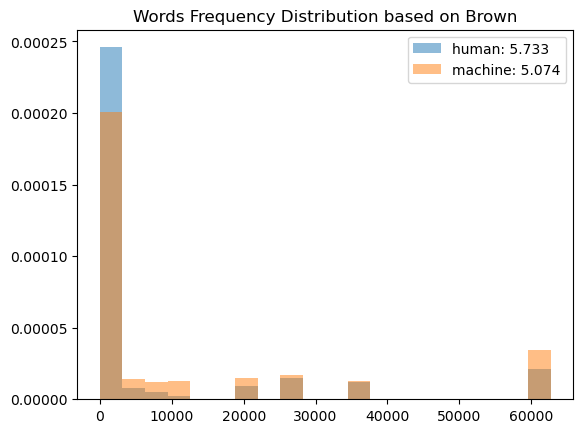

In [35]:
plt.hist(human_freq, bins=20, alpha=0.5, label=f'human: {human_words_len:.3f}', density=True)
plt.hist(machine_freq, bins=20, alpha=0.5, label=f'machine: {machine_words_len:.3f}', density=True)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Words Frequency Distribution based on Brown")
plt.savefig(f'{dataset_name}_freq.png')

### POS tagging

In [29]:
def dict_add(list_of_dicts):
    items = set().union(*list_of_dicts)
    res = {}
    for item in items:
        res[item] = sum(d.get(item, 0) for d in list_of_dicts) / len(list_of_dicts)
    return res

In [30]:
def pos_func(text, nlp):
    pos_dict = defaultdict(int)
    for sent in text:
        doc = nlp(sent)
        for sent in doc.sentences:
            for word in sent.words:
                pos_dict[word.xpos] += 1
    return pos_dict

def norm_func(human_dist, machine_dist):
    all_keys = sorted(set().union(human_dist.keys(), machine_dist.keys()))
    human_dist_norm = {k: human_dist.get(k, 0)  / sum(human_dist.values()) for k in all_keys}
    machine_dist_norm = {k: machine_dist.get(k, 0) / sum(machine_dist.values()) for k in all_keys}
    return human_dist_norm, machine_dist_norm

def pipe_add(func, all_text, nlp):
    dict_func =  [func(text, nlp) for text in tqdm(all_text)]
    dict_all = dict_add(dict_func)
    return dict_all

def draw_func(human_dist_norm, machine_dist_norm, dataset_name, func_name):
    plt.style.use('default')
    plt.bar(x=list(human_dist_norm.keys()), height=list(human_dist_norm.values()), alpha=0.5, label='human')
    plt.bar(x=list(machine_dist_norm.keys()), height=list(machine_dist_norm.values()), alpha=0.5, label='machine')

    # rotate the x-axis labels
    plt.xticks(rotation=90)
    plt.legend()
    if func_name == "deprel":
        plt.title(f'Dependency Relation Distribution on {dataset_name}')
    elif func_name == "xpos":
        plt.title(f'POS Tagging Distribution on {dataset_name}')
    plt.savefig(f'{func_name}_dist_{dataset_name}.png', dpi=300)
    plt.show()

In [ ]:
train_df.to_csv(f'{dataset_name}_train.csv', index=False)

In [31]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos')
human_text, machine_text = fetch_text(train_df)

human_dict = pipe_add(pos_func, human_text, nlp)
machine_dict = pipe_add(pos_func, machine_text, nlp)

human_norm_dict, machine_norm_dict = norm_func(human_dict, machine_dict)
draw_func(human_norm_dict, machine_norm_dict, dataset_name, "xpos")

2023-04-17 15:19:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-04-17 15:19:58 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-04-17 15:19:59 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-04-17 15:19:59 INFO: Using device: cuda
2023-04-17 15:19:59 INFO: Loading: tokenize
2023-04-17 15:20:01 INFO: Loading: pos
2023-04-17 15:20:02 INFO: Done loading processors!
  0%|          | 2/556 [00:06<28:40,  3.11s/it]

KeyboardInterrupt: 

### Dependency Parsing

In [24]:
def deprel_func(sentences, nlp):
    doc = nlp(sentences)
    deprel_dist = defaultdict(int)
    for sent in doc.sentences:
        for word in sent.words:
            deprel_dist[word.deprel] += 1
    return deprel_dist

2023-04-16 21:43:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-04-16 21:43:16 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-04-16 21:43:16 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-04-16 21:43:16 INFO: Using device: cuda
2023-04-16 21:43:16 INFO: Loading: tokenize
2023-04-16 21:43:17 INFO: Loading: pos
2023-04-16 21:43:17 INFO: Loading: lemma
2023-04-16 21:43:17 INFO: Loading: depparse
2023-04-16 21:43:18 INFO: Done loading processors!


In [25]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
human_text, machine_text = fetch_text(train_df)

human_dict = pipe_add(deprel_func, human_text, nlp)
machine_dict = pipe_add(deprel_func, machine_text, nlp)

human_norm_dict, machine_norm_dict = norm_func(human_dict, machine_dict)
draw_func(human_norm_dict, machine_norm_dict, dataset_name, "deprel")

100%|██████████| 1214/1214 [04:17<00:00,  4.71it/s]
